## Problem 1
Generate spikes for 10 s (or longer if you want better statistics) using a Poisson spike generator with a constant rate of 100 Hz, and record their times of occurrence. Compute the coefficient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms. Plot the interspike interval histogram.

c_v =  1.1011
   T           Fano
   0.0010000   1.0025148
   0.0050000   1.0611865
   0.0100000   1.1102763
   0.0500000   1.2911521
   0.1000000   1.3909950


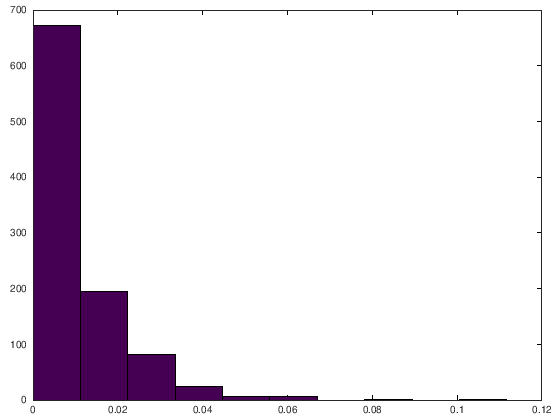

In [1]:
r = 100;
T = 10;

times = [0];
while times(end) < T
    next_time = times(end) - log(rand(1))/r;
    times = [times next_time];
end
intervals = times(2:end) - times(1:end-1);
times = times(2:end-1);

c_v = std(intervals) / mean(intervals)
hist(intervals)

fano_intervals = [0.001 0.005 0.01 0.05 0.1];
fano = [];
for dt = fano_intervals
    bins = 0:dt:T;
    counts = (floor(times / dt) * dt)';
    counts = sum((counts >= bins(1:end-1)) & (counts < bins(2:end)), 1);
    fano = [fano var(counts) / mean(counts)];
end

disp('   T           Fano')
disp([fano_intervals' fano'])

## Problem 2
Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value, $r(t) = r_0$. After every spike, set $r(t)$ to 0, and then allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$ that controls the refractory recovery rate. In other words, have $r(t)$ obey the equation

$\tau_{ref} dr/dt = r_0 − r$

except immediately after a spike, when it is set to 0. Plot the coefficient of variation as a function of $\tau_{ref}$ over the range 1 ms $\le \tau_{ref} \le$ 20 ms, and plot interspike interval histograms for a few different values of $\tau_{ref}$ in this range. Compute the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms for the case $\tau_{ref}$ = 10 ms.

   T           Fano
   0.0010000   0.9450945
   0.0050000   0.9254627
   0.0100000   0.8654109
   0.0500000   0.9858383
   0.1000000   0.9715335


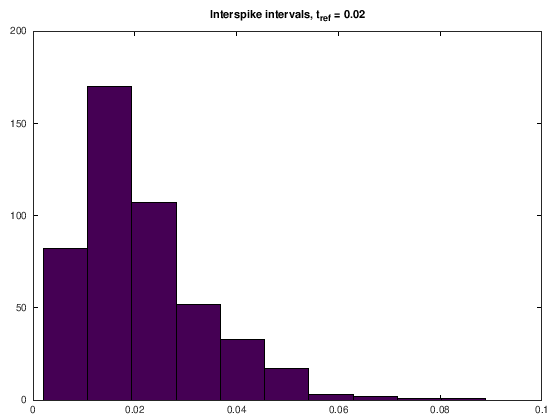

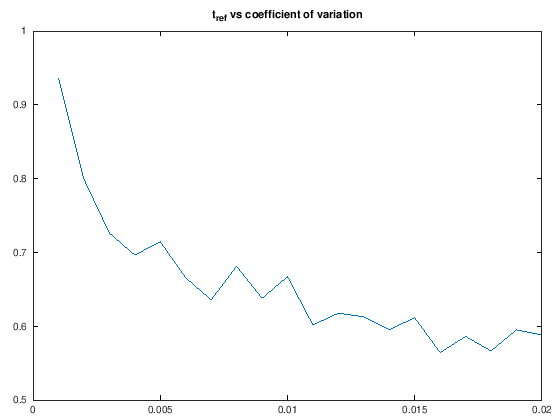

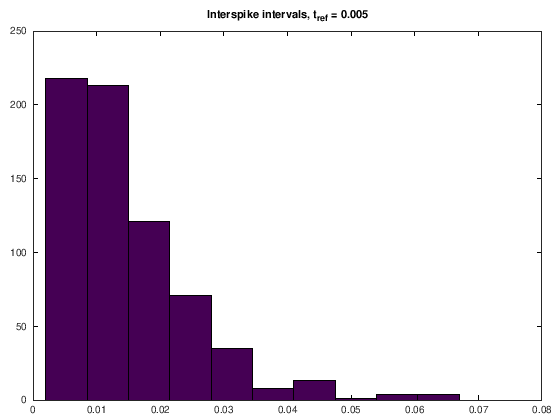

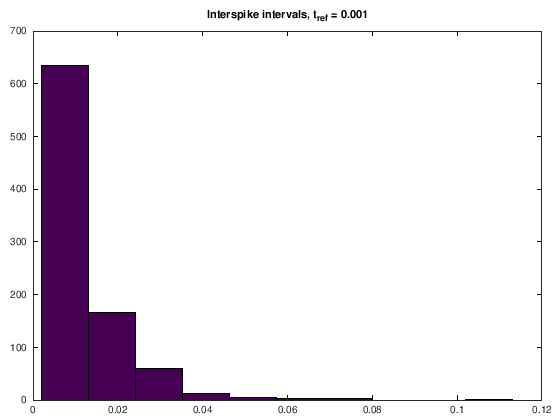

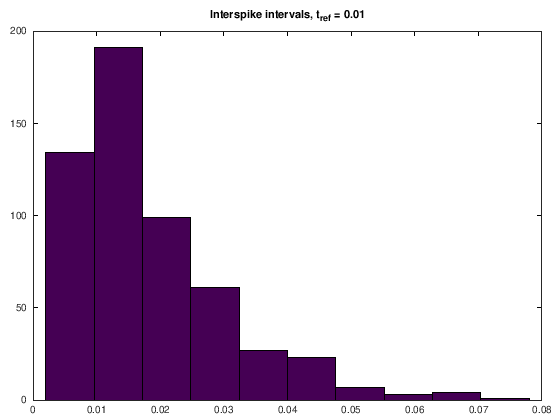

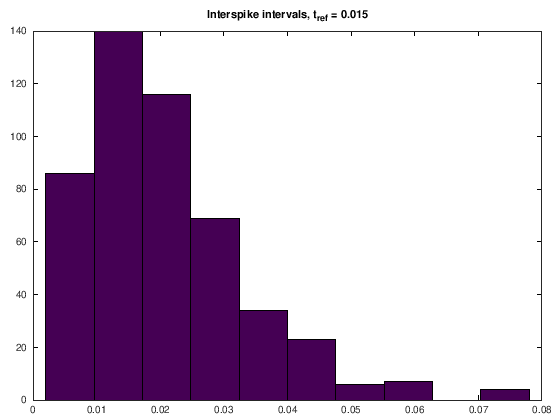

In [2]:
r0 = 100;
r = r0;
T = 10;
dt = 0.001;
times = dt:dt:T;

c_v = [];
taus = dt * floor((dt:dt:0.02) / dt);
for tau = taus
    spikes = [];
    for t = times
        is_spike = r * dt > rand(1);
        spikes = [spikes is_spike];
        if is_spike
            r = 0;
        elseif r < r0
            dr = (r0 - r) * dt / tau;
            r = r + dr;
        end
    end
    
    spike_times = times(find(spikes));
    intervals = spike_times(1:end) - [0 spike_times(1:end - 1)];
    c_v = [c_v std(intervals) / mean(intervals)];
    
    if tau == 0.001 || mod(tau, 0.005) == 0
        figure()
        hist(intervals);
        title(["Interspike intervals, t_{ref} = ", num2str(tau)])
    end
    
    if tau != 0.01
        continue
    end
    
    fano_intervals = [0.001 0.005 0.01 0.05 0.1];
    fano = [];
    for T_f = fano_intervals
        counts = sum(reshape(spikes, [], T_f / dt), 2);
        fano = [fano var(counts) / mean(counts)];
    end

    disp('   T           Fano')
    disp([fano_intervals' fano'])
end

figure()
plot(taus, c_v);
title("t_{ref} vs coefficient of variation")

## Problem 3
Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of 100 Hz, a constant firing rate of 100 Hz together with a refractory period modeled as in exercise 2 with $tau_{ref}$ = 10 ms, and a variable firing rate $r(t) = 100(1 + cos(2πt/25 ms))$ Hz. Plot the histograms over a range from 0 to 100 ms.

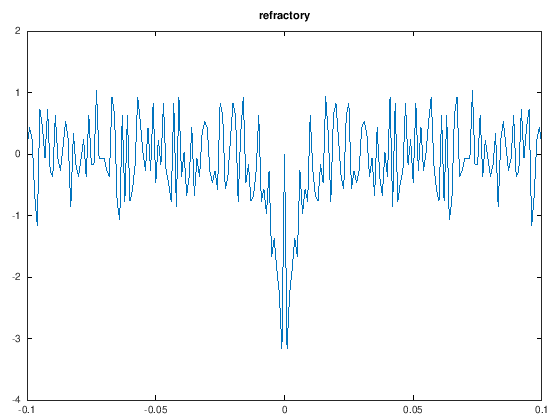

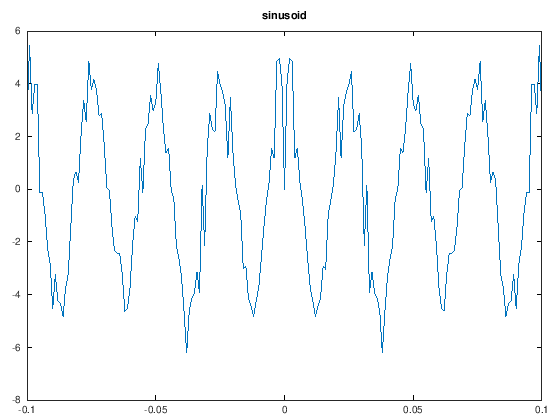

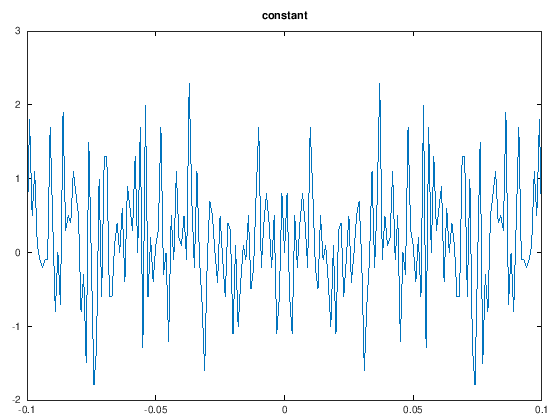

In [3]:
function retval = get_spike_train(T, dt, r0, tau, sinusoid)
    r = r0;
    retval = [];
    for t = dt:dt:T
        if isa(sinusoid, "function_handle")
            r = sinusoid(t);
        end

        is_spike = r * dt > rand(1);
        retval = [retval is_spike];
        
        if tau <= 0
            continue
        elseif is_spike
            r = 0;
        elseif r < r0
            dr = (r0 - r) * dt / tau;
            r = r + dr;
        end
    end
endfunction

function plot_autocorr(spike_times, T, bin_size, max_bin, name)
    bins = round(-max_bin/bin_size:1:max_bin/bin_size);
    n = max(size(spike_times));
    
    intervals = round((spike_times' - spike_times) / bin_size);
    intervals = intervals(find(abs(intervals) <= bins(end)));

    N = sum(intervals == bins, 1);
    autocorr = N/T - n^2 * bin_size / T^2;
    
    autocorr((max_bin / bin_size) + 1) = 0;
    figure()
    plot(bins * bin_size, autocorr);
    title(name);
endfunction

T = 10;
dt = 0.001;
r0 = 100;

spikes_const = get_spike_train(T, dt, r0, 0, 0);
spikes_refract = get_spike_train(T, dt, r0, 0.01, 0);
spikes_sin = get_spike_train(T, dt, 0, 0, @(t) 100 * (1 + cos(2 * pi * t / 0.025)));

times = dt:dt:T;
bin_size = 0.001;
max_bin = 0.1;
plot_autocorr(times(find(spikes_const)), T, bin_size, max_bin, "constant");
plot_autocorr(times(find(spikes_refract)), T, bin_size, max_bin, "refractory");
plot_autocorr(times(find(spikes_sin)), T, bin_size, max_bin, "sinusoid");